In [1]:
import subprocess
import os
print('Current conda environment:', os.environ['CONDA_DEFAULT_ENV'])
os.environ['TOKENIZERS_PARALLELISM'] = "false"

cwd = os.getcwd()
print(cwd)

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

Current conda environment: reinvent
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


## Generating data from REINVENT, CReM, SAFE, and COATI

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

from crem.crem import grow_mol, mutate_mol
crem_db = '../crem_db/crem_db2.5.db'

import mols2grid

from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator, CanonSmiles, Draw, MolFromSmiles, PandasTools
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit import DataStructs
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity
import useful_rdkit_utils as uru

import safe as sf
import datamol as dm

import mols2grid

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch

from coati.generative.coati_purifications import embed_smiles
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.simple_coati2.io import load_coati2

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


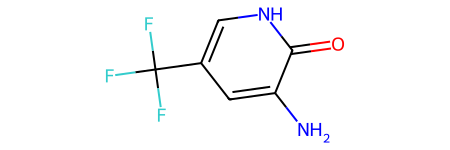

In [3]:
initial = 'Nc1cc(c[nH]c1=O)C(F)(F)F'
initial_mol = MolFromSmiles(initial)
initial_mol

In [4]:
def tanimoto_similarity(smi_1, smi_2, use_counts=True):
    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048,countSimulation=True)
    mol_1 = Chem.MolFromSmiles(smi_1)
    mol_2 = Chem.MolFromSmiles(smi_2)
    if use_counts:
        fp_1 = rdFingerprintGenerator.GetCountFPs([mol_1])[0]
        fp_2 = rdFingerprintGenerator.GetCountFPs([mol_2])[0]
    else:
        fp_1 = rdFingerprintGenerator.GetFPs([mol_1])[0]
        fp_2 = rdFingerprintGenerator.GetFPs([mol_2])[0]
    return DataStructs.TanimotoSimilarity(fp_1, fp_2)

In [5]:
def remove_odd_rings(df):
    ring_system_lookup = uru.RingSystemLookup.default()
    df['ring_systems'] = df.SMILES.apply(ring_system_lookup.process_smiles)
    df[['min_ring','min_freq']] = df.ring_systems.apply(uru.get_min_ring_frequency).to_list()
    df = df.query('min_freq > 100').copy()
    return df.iloc[:, 0:3]

### Generating analogs w/ REINVENT

In [6]:
%cd ..

arg1 = f'--input_frag'
subprocess.run(['python3', 'generate_analogs.py', arg1, initial],
               stdout=subprocess.DEVNULL,
               stderr=subprocess.STDOUT)
        
# Change directory back to that of the current notebook
%cd experiments

/home/fts_g_ucla_edu/Projects/rips-relay
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [7]:
df = pd.read_csv('data/dataframe.csv')

df.drop(['Unnamed: 0', 'Prior'], axis=1, inplace=True)

In [8]:
df = df.sample(n=500)
df['Model'] = 'reinvent'

df

,SMILES,Input_SMILES,Tanimoto,Model
148,CCC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1Cc1ccc...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.654867,reinvent
9,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.894737,reinvent
686,CC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.787879,reinvent
609,CCC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1Cc1ccc...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.685185,reinvent
1008,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cn(...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.642202,reinvent
...,...,...,...,...
517,CCCCNS(=O)(=O)Cn1c(C(=O)CC)c(-c2ccccc2)c2cc(Cl...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.711538,reinvent
169,CCC(=O)c1c(-c2cccc(F)c2)c2cc(Cl)ccc2c(=O)n1Cc1...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.733333,reinvent
520,CCC(=O)Nc1ccc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.557522,reinvent
101,CCC(=O)c1c(-c2ccccc2)c2cc(OC)ccc2c(=O)n1Cc1ccc...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.666667,reinvent


### Generating analogs w/ CReM

In [9]:
out_list = []
mutate_list = list(mutate_mol(initial_mol, db_name=crem_db, return_mol=False))

for idx, analog in enumerate(mutate_list):
    out_list.append([analog, initial])

In [10]:
temp_df = pd.DataFrame(out_list, columns=["SMILES","Input_SMILES"])

In [11]:
crem_smiles = temp_df['SMILES'].values

sim_to_initial = [tanimoto_similarity(smile, initial) for smile in crem_smiles]

In [12]:
temp_df['Tanimoto'] = sim_to_initial

temp_df = remove_odd_rings(temp_df)

temp_df['Model'] = 'crem'

In [13]:
temp_df.head()

,SMILES,Input_SMILES,Tanimoto,Model
0,Nc1cc(C(F)F)c[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.500000,crem
1,Nc1cc(-c2ccccc2)c[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.339623,crem
2,Nc1cc([N+](=O)[O-])c[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.428571,crem
3,NC12CC3CC(C1)CC(F)(C3)C2,Nc1cc(c[nH]c1=O)C(F)(F)F,0.031746,crem
4,Nc1cc(-c2nn[nH]n2)ccc1F,Nc1cc(c[nH]c1=O)C(F)(F)F,0.192982,crem


In [14]:
df = pd.concat((df, temp_df))

In [15]:
df

,SMILES,Input_SMILES,Tanimoto,Model
148,CCC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1Cc1ccc...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.654867,reinvent
9,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.894737,reinvent
686,CC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.787879,reinvent
609,CCC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1Cc1ccc...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.685185,reinvent
1008,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cn(...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.642202,reinvent
...,...,...,...,...
480,O=c1[nH]cc(C(F)(F)F)cc1I,Nc1cc(c[nH]c1=O)C(F)(F)F,0.675676,crem
481,N#Cc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.625000,crem
482,O=c1[nH]cc(C(F)(F)F)cc1O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.675676,crem
483,O=C(O)c1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.595238,crem


### Generating analogs w/ COATI

In [ ]:
encoder1, tokenizer1 = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=torch.device("cuda:0"),
    doc_url="s3://terray-public/models/barlow_closed.pkl"
)

encoder2, tokenizer2 = load_coati2(
    freeze=True,
    device=torch.device("cuda:0"),
    doc_url="s3://terray-public/models/coati2_chiral_03-08-24.pkl"
)

In [17]:
def gen_mol(smiles, coati_version=1, num_variations=100, noise_scale=0.15):

    # Embed the SMILES string
    smiles = CanonSmiles(smiles)

    if coati_version == 1:
        vector = embed_smiles(smiles, encoder1, tokenizer1)
    elif coati_version == 2:
        vector = embed_smiles(smiles, encoder2, tokenizer2)

    # Noise is added as an isotropic Gaussian with std=noise_scale
    if coati_version == 1:
        nearby_smiles = encoder1.hclip_to_2d_batch(
            h_clip=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer1,
            noise_scale=noise_scale
        )
    elif coati_version == 2:
        nearby_smiles = encoder2.hcoati_to_2d_batch(
            h_coati=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer2,
            noise_scale=noise_scale,
        )

    # Retrieve canonical SMILES of generated analogs
    unique_valid_smiles = list(set([CanonSmiles(smi) for smi in nearby_smiles if MolFromSmiles(smi)]))

    # Store true if original molecule is in the set of generated analogs
    had_orig = smiles in unique_valid_smiles

    unique_valid_smiles = list(set([smiles] + unique_valid_smiles))

    # Generate molecular fingerprints
    fp = RDKFingerprint(MolFromSmiles(smiles), minPath=1, maxPath=7, fpSize=2048)
    fps = [RDKFingerprint(MolFromSmiles(x), minPath=1, maxPath=7, fpSize=2048) for x in unique_valid_smiles]

    # Compute tanimoto similarities between distributions and store as list of strings
    sim = BulkTanimotoSimilarity(fp, fps)
    sim_str = [str(round(x, 2)) for x in sim]

    unique_valid_smiles, sim_str = zip(*sorted(zip(unique_valid_smiles, sim_str), key=lambda x:x[1], reverse=True))

    if not had_orig:
        unique_valid_smiles, sim_str = zip(*[[i, f"{j} (Added)"] if i==smiles else [i, j] for i, j in zip(unique_valid_smiles, sim_str)])

    # Output for molecule generation
    print (f"Attempted {num_variations} COATI{coati_version} generations with a noise scale of {noise_scale} and generated {len(unique_valid_smiles)} unique structures.")
    
    # Display molecules and tanimoto similarity to initial fragment
    # display(Draw.MolsToGridImage([MolFromSmiles(s) for s in unique_valid_smiles], molsPerRow=5, subImgSize=(200, 200), maxMols=100, legends=sim_str))
    
    return unique_valid_smiles

In [18]:
coati_smiles = gen_mol(initial, coati_version = 2, num_variations = 1000, noise_scale = 0.5)

Attempted 1000 COATI2 generations with a noise scale of 0.5 and generated 256 unique structures.


In [19]:
temp_df = pd.DataFrame()
temp_df['SMILES'] = coati_smiles
temp_df['Input_SMILES'] = initial

len(temp_df)

256

In [20]:
sim_to_initial = [tanimoto_similarity(smile, initial) for smile in coati_smiles]

temp_df['Tanimoto'] = sim_to_initial

temp_df = remove_odd_rings(temp_df)

temp_df['Model'] = 'coati'

len(temp_df)

215

In [21]:
temp_df.head()

,SMILES,Input_SMILES,Tanimoto,Model
0,Nc1cc(C(F)(F)F)c[nH]c1=O.[2H],Nc1cc(c[nH]c1=O)C(F)(F)F,0.968750,coati
1,Nc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,1.000000,coati
2,Cl.Nc1cc(C(F)(F)F)c[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.968750,coati
3,Nc1cc(C(F)F)c[nH]c1=O,Nc1cc(c[nH]c1=O)C(F)(F)F,0.500000,coati
4,CC(F)(F)c1c[nH]c(=O)c(N)c1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.722222,coati


In [22]:
df = pd.concat((df, temp_df))

In [23]:
df

,SMILES,Input_SMILES,Tanimoto,Model
148,CCC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1Cc1ccc...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.654867,reinvent
9,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.894737,reinvent
686,CC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.787879,reinvent
609,CCC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1Cc1ccc...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.685185,reinvent
1008,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cn(...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.642202,reinvent
...,...,...,...,...
247,Nc1nc(C(F)(F)F)c[nH]1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.390244,coati
248,Nc1cc(=O)oc2ccc(F)cc12,Nc1cc(c[nH]c1=O)C(F)(F)F,0.218182,coati
249,Nc1cc(Cl)c(C(=O)OC(F)(F)F)[nH]1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.313725,coati
250,Nc1cc(CC(F)(F)F)oc(=O)c1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.354167,coati


### Generating analogs w/ SAFE

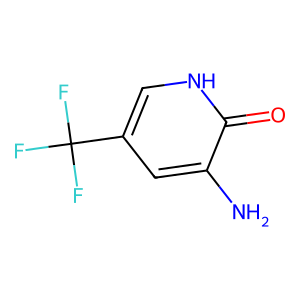

In [24]:
initial_mol = dm.to_mol(initial)
display(dm.to_image(initial_mol))

In [ ]:
designer = sf.SAFEDesign.load_default(verbose=True)

designer.model

In [ ]:
safe_smiles = designer.de_novo_generation(sanitize=True, n_samples_per_trial=500)

safe_smiles

In [27]:
temp_df = pd.DataFrame()
temp_df['SMILES'] = safe_smiles
temp_df['Input_SMILES'] = initial

In [28]:
len(temp_df)

465

In [29]:
sim_to_initial = [tanimoto_similarity(smile, initial) for smile in safe_smiles]

temp_df['Tanimoto'] = sim_to_initial

temp_df = remove_odd_rings(temp_df)

temp_df['Model'] = 'safe'

len(temp_df)

395

In [30]:
df = pd.concat((df, temp_df))

In [31]:
df

,SMILES,Input_SMILES,Tanimoto,Model
148,CCC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1Cc1ccc...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.654867,reinvent
9,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.894737,reinvent
686,CC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.787879,reinvent
609,CCC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1Cc1ccc...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.685185,reinvent
1008,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cn(...,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,0.642202,reinvent
...,...,...,...,...
459,CC[NH+](CC)[C@H](CNC(=O)[C@H](C)C[NH2+]C)c1ccsc1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.061728,safe
460,O=C(O)c1csc(CC2(CCCl)CC2)n1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.058824,safe
462,CN(C(=O)C1CCCCCCC1)[C@H]1CCCN(C(=O)Cn2cccn2)CC1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.038095,safe
463,C[S+]([O-])c1ccc2ncnc(-c3ccc(Cn4ccnc4)cc3)c2c1,Nc1cc(c[nH]c1=O)C(F)(F)F,0.061224,safe


## Visualizing the models in chemical space

### PCA

In [32]:
smiles = df['SMILES'].values
mols = [MolFromSmiles(smile) for smile in smiles]

In [33]:
fpgen = AllChem.GetMorganGenerator()

fingerprints = [fpgen.GetFingerprint(mol).ToList() for mol in mols]

In [34]:
df['Fingerprints'] = fingerprints

In [35]:
X = fingerprints

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [36]:
pca = PCA(n_components=3, random_state=0)
pca_fps = pca.fit_transform(X)

In [37]:
var1, var2, var3 = pca.explained_variance_ratio_

In [38]:
df['PC1'], df['PC2'], df['PC3'] = pca_fps.T[0], pca_fps.T[1], pca_fps.T[2]

In [39]:
plot_df = df.sample(n=500)

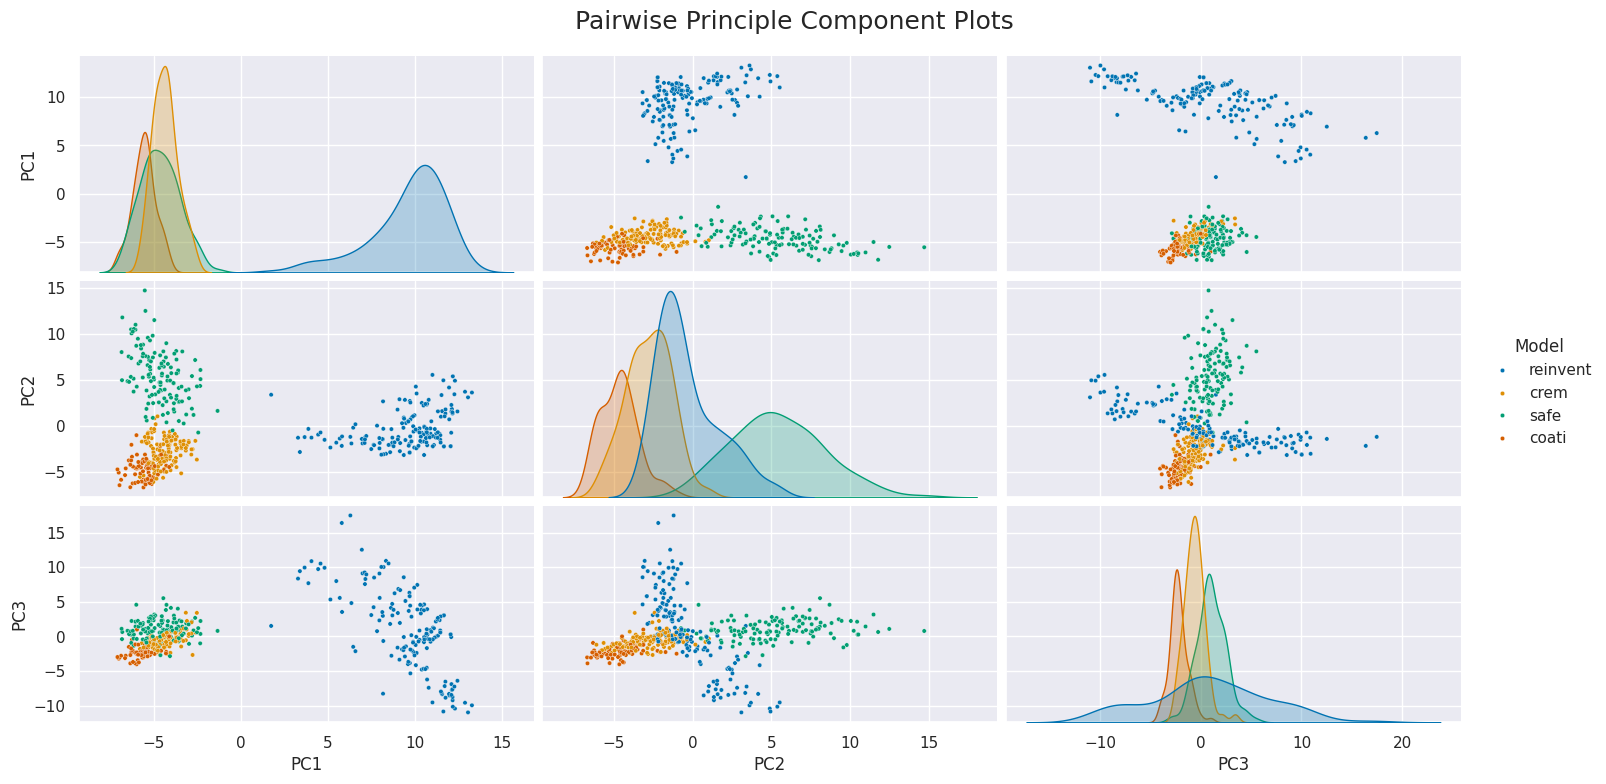

In [40]:
f = sns.pairplot(plot_df,
                 hue='Model',
                 vars=['PC1', 'PC2', 'PC3'],
                 palette='colorblind',
                 aspect=2,
                 plot_kws=dict(s=10))

f.fig.suptitle('Pairwise Principle Component Plots', fontsize=18, y=1.04);

### t-SNE

In [41]:
p = 50

pca_model = PCA(n_components=5, random_state=0)
tsne_model = TSNE(n_components=2, random_state=0, perplexity=p, n_iter=5000)
tsne_fps = tsne_model.fit_transform(pca_model.fit_transform(X))

In [42]:
df['TSNE1'], df['TSNE2'] = tsne_fps.T[0], tsne_fps.T[1]

In [43]:
plot_df = df.sample(n=500)

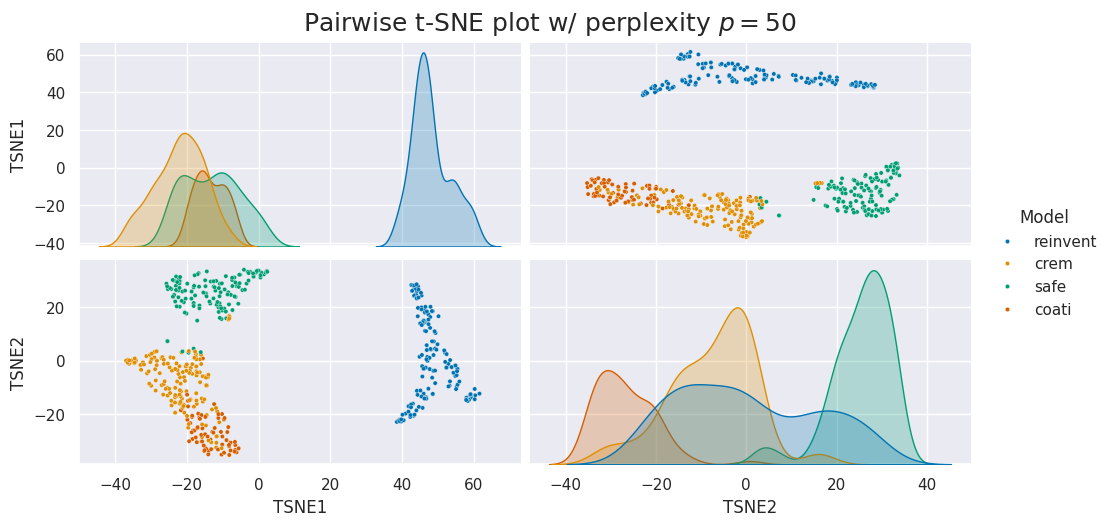

In [44]:
f = sns.pairplot(plot_df,
                 hue='Model',
                 vars=['TSNE1', 'TSNE2'],
                 palette='colorblind',
                 aspect=2,
                 plot_kws=dict(s=10))

title = f'Pairwise t-SNE plot w/ perplexity $p={p}$'

f.fig.suptitle(title, fontsize=18, y=1.04);